## Fetch data directory path

In [7]:
import os
from dotenv import load_dotenv

load_dotenv()
data_dir_path = os.environ['DATA_DIR_PATH']

## Data preview

In [21]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

In [38]:
def show_kspace_slice(kspace_path, slice_idx=0, coil_idxs=[0, 5, 10], cmap=None):
    # convert kspace slice to real image
    hf = h5py.File(kspace_path)
    kspace_slice = hf['kspace'][slice_idx]
    kspace_slice = np.log(np.abs(kspace_slice) + 1e-9)
    
    kspace_title = kspace_path.split('/')[-1]
    
    plt.figure()
    plt.suptitle(f'{kspace_title} - slice {slice_idx}')
    for i, coil_idx in enumerate(coil_idxs):
        ax = plt.subplot(1, len(coil_idxs), i + 1)
        plt.title(f'coil {coil_idx}')
        ax.imshow(kspace_slice[coil_idx], cmap=cmap)
        plt.axis('off')  # Remove axes for a cleaner look
    
    plt.show()

In [39]:
def show_image_slices(img_path, slice_idxs=[0], cmap='gray'):
    img_keys = ['image_grappa', 'image_input', 'image_label']
    img_title = img_path.split('/')[-1]
    
    for i, slice_idx in enumerate(slice_idxs):
        hf = h5py.File(img_path)
        plt.figure()
        plt.suptitle(f'{img_title} - slice {slice_idx}')
        for j, key in enumerate(img_keys):
            ax = plt.subplot(1, len(img_keys), j + 1)
            img_slice = hf[key][slice_idx]
            plt.title(key)
            ax.imshow(img_slice, cmap=cmap)
            plt.axis('off')  # Remove axes for a cleaner look
        
        plt.show()

In [40]:
def get_masked_kspace_with_1d_mask(kspace, mask):
    
    mask = np.tile(mask, (mask.shape[0], 1))

<Figure size 1500x1600 with 0 Axes>

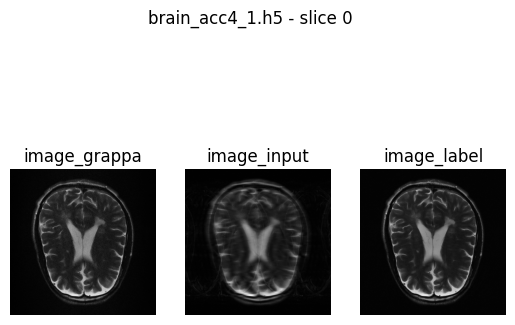

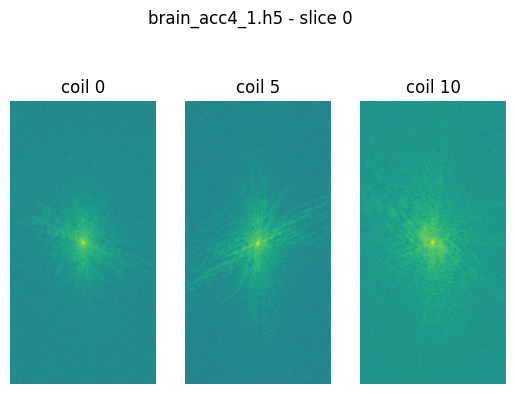

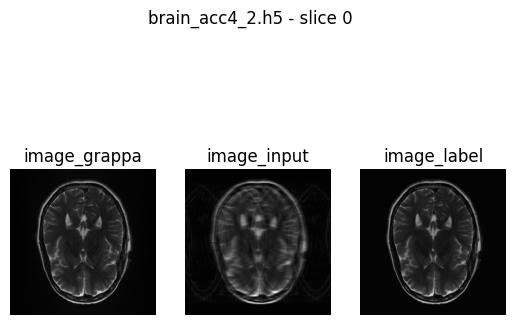

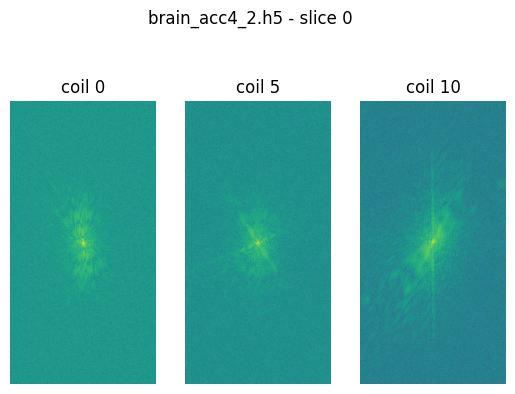

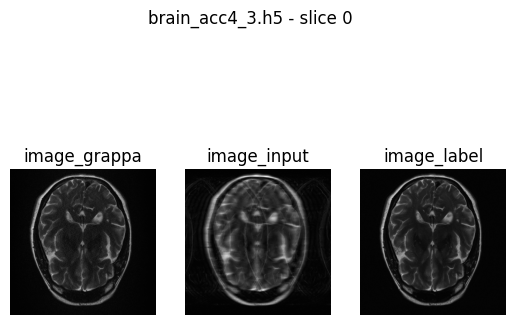

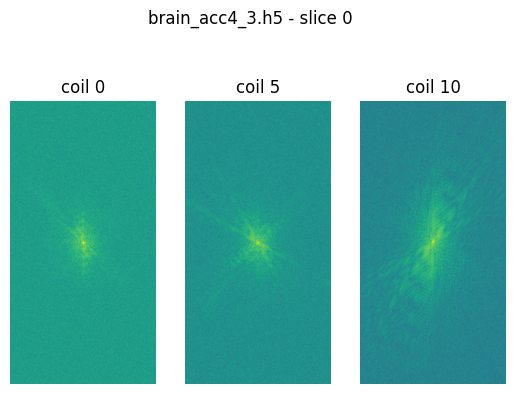

In [41]:
plt.figure(figsize=(15, 16))
for i in range(1, 4):
    img_path = f'{data_dir_path}/train/image/brain_acc4_{i}.h5'
    show_image_slices(img_path)
    
    kspace_path = f'{data_dir_path}/train/kspace/brain_acc4_{i}.h5'
    show_kspace_slice(kspace_path)